In [7]:
%%capture
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json

import copy
from astropy.io import fits
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO
import component_separation.interface as cslib
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw

from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)
import warnings
warnings.filterwarnings('ignore')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter
lmaxbins = int(bins[-1][1])
colors=csu.CB_color_cycle
def std_dev_binned(d, lmax=3000, binwidth=200, log=True):
    if log == False:
        bins = np.linspace(0, lmax+1, binwidth)
    else:
        bins = np.logspace(np.log10(1), np.log10(lmax+1), binwidth)

    bl = bins[:-1]
    br = bins[1:]
    if type(d) == np.ndarray:
        val = np.nan_to_num(d)
    elif type(d) == np.ma.core.MaskedArray:
        val = np.nan_to_num(d)
    else:
        val = np.nan_to_num(d.to_numpy())
    print(np.linspace(0,lmax,lmax).shape, bins.shape,val.shape)
    n, _ = np.histogram(
        np.linspace(0,lmax,lmax),
        bins=bins)
    sy, _ = np.histogram(
        np.linspace(0,lmax,lmax),
        bins=bins,
        weights=val)
    sy2, _ = np.histogram(
        np.linspace(0,lmax,lmax),
        bins=bins,
        weights=val * val)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    return mean, std, _

In [8]:
dxb = io.load_beamf(csu.freqcomb)
cfc = copy.deepcopy(csu.cf)
cfc['pa']['freqdset'] = 'NPIPE'
csuc = Config(cfc)
ioc = IO(csuc)
dxn = ioc.load_beamf(csuc.freqcomb)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'lens', 'freqdset': 'NPIPE', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_lowell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 'ET', 'BT', 'BE'], 'nside_desc_map': [1024, 2048]}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [9]:
LFI_dict = {
    "030": 28,
    "044": 29,
    "070": 30
}
idx=0
lab1='NPIPE'
for freqc in csu.freqcomb:
    freqs = freqc.split('-')
    if freqs[0] == freqs[1]:
        idx+=1
        if int(freqs[0]) < 100:
            pass
            dxd = 1/dxb[freqc]["LFI"][LFI_dict[freqs[0]]].data.field(0)[:2049]
            nd = 1/dxn[freqc]["HFI"][1].data.field(0)[:2049]
        elif int(freqs[0]) >= 100:
            dxd = 1/dxb[freqc]["HFI"][1].data.field(1)[:4000]
            nd = 1/dxn[freqc]["HFI"][1].data.field(0)[:4000]
        plt.plot(nd, color='black', label=lab1, lw=2)
        plt.plot(dxd, color=colors[idx], label=freqs[0], lw=3, alpha=0.8)
        lab1=None
plt.yscale('log')
plt.xlim((0,4000))
plt.ylim((1e0,1e3))
plt.legend()
plt.show()

idx=0
lab1='NPIPE'
for freqc in csu.freqcomb:
    freqs = freqc.split('-')
    if freqs[0] == freqs[1]:
        idx+=1
        if int(freqs[0]) < 100:
            pass
            dxd = 1/dxb[freqc]["LFI"][LFI_dict[freqs[0]]].data.field(0)[:2049]
            nd = 1/dxn[freqc]["HFI"][1].data.field(0)[:2049]
        elif int(freqs[0]) >= 100:
            dxd = 1/dxb[freqc]["HFI"][1].data.field(1)[:4000]
            nd = 1/dxn[freqc]["HFI"][1].data.field(0)[:4000]
        plt.plot((nd-dxd)/dxd, color=colors[idx], label=freqs[0], lw=3)
# plt.yscale('log')
plt.xlim((0,4000))
plt.ylim((-0.1,0.1))
plt.legend()

KeyError: 'LFI'

In [10]:
import component_separation.transform_spec as trsf_s
_Tscale = "K_CMB"#csu.Tscale
C_lN = io.load_powerspectra('noise', processed=False)
# C_lN = trsf_s.process_all(C_lN, csu.cf,
#                           csu.freqcomb,
#                           csu.PLANCKSPECTRUM,
#                           dxb, csu.nside_out,
#                           csu.cf['pa']["Spectrum_scale"],
#                           csu.cf['pa']['smoothing_window'],
#                           csu.cf['pa']['max_polynom'])
cov_lN = pw.build_covmatrices(C_lN, _Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lNEE = cov_lN[1]
for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n != m:
            cov_lNEE[n,m] = np.zeros(shape=cov_lNEE.shape[2])
print(cov_lNEE.shape)

C_lN_n = ioc.load_powerspectra('noise', processed=False)
# C_lN_n = trsf_s.process_all(C_lN_n, csuc.cf,
#                           csu.freqcomb,
#                           csu.PLANCKSPECTRUM,
#                           dxn, csu.nside_out,
#                           csu.cf['pa']["Spectrum_scale"],
#                           csu.cf['pa']['smoothing_window'],
#                           csu.cf['pa']['max_polynom'])
cov_lN_n = pw.build_covmatrices(C_lN_n, _Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lNEE_n = cov_lN_n[1]
for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n != m:
            cov_lNEE_n[n,m] = np.zeros(shape=cov_lNEE.shape[2])
print(cov_lNEE.shape)

loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_diff/SPEC-RAW_0200_C_l_NPIPE_diff_lens_4000_6000_Full.npy
(7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_diff/SPEC-RAW_0200_C_l_NPIPE_diff_lens_4000_6000_Full.npy
(7, 7, 4001)


(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)


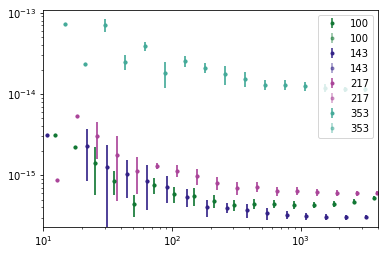

(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)
(4001,) (25,) (4001,)


(10, 4000)

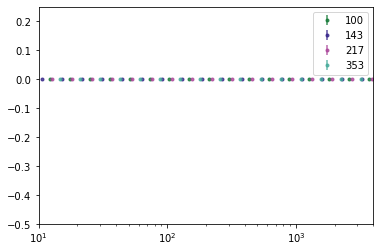

In [11]:
for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n == m and n>=3:
            a = cov_lNEE[n,m,:]
            b = cov_lNEE_n[n,m,:]
#             plt.plot(a, color='black')
#             plt.plot(b, color=colors[n], label=csu.PLANCKMAPFREQ_f[n])
            mean, err, _ = std_dev_binned(b, lmax=4001, binwidth=25)
            plt.errorbar(n*np.logspace(np.log10(1), np.log10(lmax+1), 24)+(_[1:]+_[:-1])/2, mean, yerr=err, label=csu.PLANCKMAPFREQ_f[n], alpha=1, fmt= '.', color=colors[n])
            mean, err, _ = std_dev_binned(a, lmax=4001, binwidth=25)
            plt.errorbar(n*np.logspace(np.log10(1), np.log10(lmax+1), 24)+(_[1:]+_[:-1])/2, mean, yerr=err, label=csu.PLANCKMAPFREQ_f[n], alpha=0.5, fmt= '.', color=colors[n])                               
plt.legend()
# plt.ylim((2e-4,4e-3))
plt.xscale('log')
plt.yscale('log')
plt.xlim((10,lmax))
plt.show()


for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n == m and n>2:
            a = cov_lNEE[n,m,:]
            b = cov_lNEE_n[n,m,:]
#             plt.plot(a, color='black')
#             plt.plot(b, color=colors[n], label=csu.PLANCKMAPFREQ_f[n])
            mean, err, _ = std_dev_binned((b-a)/a, lmax=4001, binwidth=25)
            plt.errorbar(n*np.logspace(np.log10(1), np.log10(lmax+1), 24)+(_[1:]+_[:-1])/2, mean, yerr=err, label=csu.PLANCKMAPFREQ_f[n], alpha=0.8, fmt= '.', color=colors[n])
plt.legend()
plt.ylim((-0.5,0.25))
plt.xscale('log')
plt.xlim((10,lmax))
# plt.yscale('log')